# Creating a LlamaIndex RAG Pipeline with NL2SQL and Metadata Filtering!

> Indented block



We'll be putting together a system for querying both qualitative and quantitative data using LlamaIndex.

The acitvities will be broken down as follows:

- 🤝 Breakout Room #1
  - Task 1: Load Dependencies
  - Task 2: Set Env Variables and Set Up WandB Callback
  - Task 3: Initialize Settings
  - Task 4: Semantic RAG Pipeline with Metadata Filtering
- 🤝 Breakout Room #2
  - Task 1: Quantitative RAG Pipeline with NL2SQL Tooling
  - Task 2: Combined RAG Pipeline

Before we get started, however, a quick note on terminology.


### A note on terminology:

You'll notice that there are quite a few similarities between LangChain and LlamaIndex. LlamaIndex can largely be thought of as an extension to LangChain, in some ways - but they moved some of the language around. Let's spend a few moments disambiguating the language.

- `QueryEngine` -> `LCEL Chain`:
  -  `QueryEngine` is just LlamaIndex's way of indicating something is an LLM "chain" on top of a retrieval system
- `OpenAIAgent` vs. `Agent`:
  - The two agents have the same fundamental pattern: Decide which of a list of tools to use to answer a user's query.
  - `OpenAIAgent` (LlamaIndex's primary agent) does not need to rely on an agent excecutor due to the fact that it is leveraging OpenAI's [functional api](https://openai.com/blog/function-calling-and-other-api-updates) which allows the agent to interface "directly" with the tools instead of operating through an intermediary application process.

There is, however, a much large terminological difference when it comes to discussing data.

##### Nodes vs. Documents

As you're aware of from the previous weeks assignments, there's an idea of `documents` in NLP which refers to text objects that exist within a corpus of documents.

LlamaIndex takes this a step further and reclassifies `documents` as `nodes`. Confusingly, it refers to the `Source Document` as simply `Documents`.

The `Document` -> `node` structure is, almost exactly, equivalent to the `Source Document` -> `Document` structure found in LangChain - but the new terminology comes with some clarity about different structure-indices.

We won't be leveraging those structured indicies today, but we will be leveraging a "benefit" of the `node` structure that exists as a default in LlamaIndex, which is the ability to quickly filter nodes based on their metadata.

![image](https://i.imgur.com/B1QDjs5.png)

# 🤝 Breakout Room #1

## BOILERPLATE

This is only relevant when running the code in a Jupyter Notebook.

In [1]:
import nest_asyncio

nest_asyncio.apply()

import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## Task 1: Load Dependencies

Let's grab our core `llama-index` library, as well as OpenAI's Python SDK.

We'll be leveraging OpenAI's suite of APIs to power our RAG pipelines today.

> NOTE: You can safely ignore any pip errors that occur during the running of these cells.

In [2]:
!pip install -qU llama-index openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

We'll be using [Weights and Biases](https://docs.wandb.ai/guides/prompts) (WandB) again for today's notebook!

In [3]:
!pip install -qU wandb llama-index-callbacks-wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


We'll be collecting our semantic data from Wikipedia - and so will need the [Wikipedia Reader](https://github.com/run-llama/llama_index/tree/main/llama-index-integrations/readers/llama-index-readers-wikipedia)!

In [4]:
!pip install -qU wikipedia llama-index-readers-wikipedia

  Preparing metadata (setup.py) ... done


Our vector database today will be powered by [ChromaDB](https://github.com/chroma-core/chroma) and so we'll need that package as well!

In [5]:
!pip install -qU chromadb llama-index-vector-stores-chroma

Finally, we'll need to grab a few dependencies related to our quantitative data!

In [6]:
!pip install -q -U sqlalchemy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 19.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.23.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


We'll grab some additional miscellaneous dependencies here.

In [7]:
!pip install -U -q tiktoken==0.4.0 sentence-transformers==2.2.2 pydantic==1.10.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.3 MB/s eta 0:00:00


## Task 2: Set Env Variables and Set Up WandB Callback

Let's set our API keys for both OpenAI and WandB!

In [8]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

OpenAI API Key: ··········


In [12]:
os.environ["WANDB_API_KEY"] = getpass.getpass("WandB API Key: ")

WandB API Key: ··········


We'll also need to set a callback handler for WandB to ensure smooth operation of our traces!

In [14]:
import llama_index
from llama_index.core import set_global_handler

set_global_handler("wandb", run_args={"project": "aie1-llama-index-demo"})
wandb_callback = llama_index.core.global_handler

### Task 3: Settings

LlamaIndex lets us set global settings which we can use to influence the default behaviour of our components.

Let's set our LLM and our Embedding Model!

In [15]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

Settings.llm = OpenAI(model="gpt-3.5-turbo")
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")

## Task 4: Semantic RAG Pipeline with Metadata Filtering

Now we can get to work creating our semantic `QueryEngine`!

We'll start, as we normally do, by grabbing some data.

> NOTE: Remember that a query engine is just a different word for a chain!

### Data Collection

We're just going to be pulling information straight from Wikipedia using the built in `WikipediaReader`.

> NOTE: Setting `auto_suggest=False` ensures we run into fewer auto-correct based errors.

In [16]:
from llama_index.readers.wikipedia import WikipediaReader

movie_list = ["Dune (2021 film)", "Dune: Part Two"]

wiki_docs = WikipediaReader().load_data(pages=movie_list, auto_suggest=False)

### Initializing our VectorStoreIndex with ChromaDB

ChromaDB is a locally hostable and open-source vector database solution.

It offers powerful features like metadata filtering out of the box, and will suit our needs well today!

We'll start by creating our local `EphemeralClient()` (in-memory and not meant for production use-cases) and our collection.

Then we'll create our `VectorStore` and `StorageContext` which will allow us to create an empty `VectorStoreIndex` which we will be able to add nodes to later!

In [17]:
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb

chroma_client = chromadb.EphemeralClient()
chroma_collection = chroma_client.create_collection("dune-v0")

In [18]:
from llama_index.core import VectorStoreIndex
from llama_index.core import StorageContext

vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents([], storage_context=storage_context)

wandb: Logged trace tree to W&B.


### Node Construction

Now we will loop through our documents and metadata and construct nodes.

We'll make sure to explicitly associate our nodes with their respective movie so we can filter by the movie title in the upcoming cells.

> NOTE: You can safely ignore any WARNINGs in the following cell.

In [19]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.core.extractors import TitleExtractor

pipeline = IngestionPipeline(transformations=[TokenTextSplitter()])

for movie, wiki_doc in zip(movie_list, wiki_docs):
    nodes = pipeline.run(documents=wiki_docs)
    for node in nodes:
        node.metadata = {"title" : movie}
    index.insert_nodes(nodes)

Add of existing embedding ID: 3289edc5-55e6-44fb-b3c6-51864f0b256c


Add of existing embedding ID: 413d0a25-7e36-44b9-b657-d5d52fdbf28e


Add of existing embedding ID: c43a4fd2-d59b-4931-9162-c701dc396135


Add of existing embedding ID: 3eb0eb55-629b-4be7-bd85-0cd707638f39


Add of existing embedding ID: 58253778-26c9-484f-865a-918334e6db29


Add of existing embedding ID: 6e3148e8-5c74-420e-bf2f-495e88b602ae


Add of existing embedding ID: a28eb0f3-16cd-45a9-90fd-bbe1aa3d90a0


Add of existing embedding ID: 115d95b1-0b25-47f3-8af1-284d02e2933b


Add of existing embedding ID: 52403767-1d50-46ef-8c7a-d8c3a145ff8c


Add of existing embedding ID: 12e190ed-54ef-43c4-bf5f-d304b9cb7285


Add of existing embedding ID: e3035b01-6e19-4379-b767-1079cf4f5440


Add of existing embedding ID: 652fcd59-e971-4af7-b06d-84c80571aa22


Add of existing embedding ID: c67016fe-063b-4588-8808-f289ecdf3d60


Add of existing embedding ID: c0ca49e6-7945-4c3a-8762-2be938ef73a2


Add of existing embedding ID: a44f76c0-27f9-49e0-83b6-114d1702a198


Add of existing embedding ID: 55bd35a8-9751-4250-ba35-51d21a70fbe8


Add of existing embedding ID: 5ccca6b8-61bc-45fd-abdd-1ccdb428b2cc


Add of existing embedding ID: fed1cc79-492a-45a1-8fe0-990ce7441da8


Add of existing embedding ID: 6946a706-1fc9-4627-bfba-613ab9a92fba


Add of existing embedding ID: 1f7f7de7-6beb-44fb-bdd6-167c30096209


Add of existing embedding ID: 385ae875-4acc-4a41-a47e-49cff791cfd2


Add of existing embedding ID: 52fe5351-90e1-485e-9007-4746c47ec0b3


Insert of existing embedding ID: 3289edc5-55e6-44fb-b3c6-51864f0b256c


Insert of existing embedding ID: 413d0a25-7e36-44b9-b657-d5d52fdbf28e


Insert of existing embedding ID: c43a4fd2-d59b-4931-9162-c701dc396135


Insert of existing embedding ID: 3eb0eb55-629b-4be7-bd85-0cd707638f39


Insert of existing embedding ID: 58253778-26c9-484f-865a-918334e6db29


Insert of existing embedding ID: 6e3148e8-5c74-420e-bf2f-495e88b602ae


Insert of existing embedding ID: a28eb0f3-16cd-45a9-90fd-bbe1aa3d90a0


Insert of existing embedding ID: 115d95b1-0b25-47f3-8af1-284d02e2933b


Insert of existing embedding ID: 52403767-1d50-46ef-8c7a-d8c3a145ff8c


Insert of existing embedding ID: 12e190ed-54ef-43c4-bf5f-d304b9cb7285


Insert of existing embedding ID: e3035b01-6e19-4379-b767-1079cf4f5440


Insert of existing embedding ID: 652fcd59-e971-4af7-b06d-84c80571aa22


Insert of existing embedding ID: c67016fe-063b-4588-8808-f289ecdf3d60


Insert of existing embedding ID: c0ca49e6-7945-4c3a-8762-2be938ef73a2


Insert of existing embedding ID: a44f76c0-27f9-49e0-83b6-114d1702a198


Insert of existing embedding ID: 55bd35a8-9751-4250-ba35-51d21a70fbe8


Insert of existing embedding ID: 5ccca6b8-61bc-45fd-abdd-1ccdb428b2cc


Insert of existing embedding ID: fed1cc79-492a-45a1-8fe0-990ce7441da8


Insert of existing embedding ID: 6946a706-1fc9-4627-bfba-613ab9a92fba


Insert of existing embedding ID: 1f7f7de7-6beb-44fb-bdd6-167c30096209


Insert of existing embedding ID: 385ae875-4acc-4a41-a47e-49cff791cfd2


Insert of existing embedding ID: 52fe5351-90e1-485e-9007-4746c47ec0b3


####❓ Question #1:

What `metadata` fields will the nodes in our index have?

Please write the code to find this information.

### **ANSWER:

Each node in our system will contain metadata fields such as `node_content`, `node_type`, `doc_id`, `document_id`, `ref_doc_id`, and `title`.


In [31]:
### YOUR CODE HERE
chroma_collection.get(limit=1)['metadatas']
chroma_collection.get(limit=1).keys()

result = chroma_collection.get(limit=1)

metadatas = result['metadatas']

first_metadata = metadatas[0]

metadata_fields = first_metadata.keys()

metadata_fields

dict_keys(['_node_content', '_node_type', 'doc_id', 'document_id', 'ref_doc_id', 'title'])

### Persisting and Loading Stored Index with Weights and Biases

Now we can utilize a powerful feature of Weights and Biases - index and artifact versioning!

We can persist our index to WandB to be used and loaded later!

In [32]:
wandb_callback.persist_index(index, index_name="dune-index-chromadb")

wandb: Adding directory to artifact (/content/wandb/run-20240312_191552-1exvg65b/files/storage)... Done. 0.0s


Now we can load our index from WandB, which is a truly powerful tool!

In [34]:
from llama_index.core import load_index_from_storage

storage_context = wandb_callback.load_storage_context(
    artifact_url="vectorize/aie1-llama-index-demo/dune-index-chromadb:v1"
)

wandb:   4 of 4 files downloaded.  


####❓ Question #2:

Provide a screenshot of your index version history as shown in WandB.


### **ANSWER:

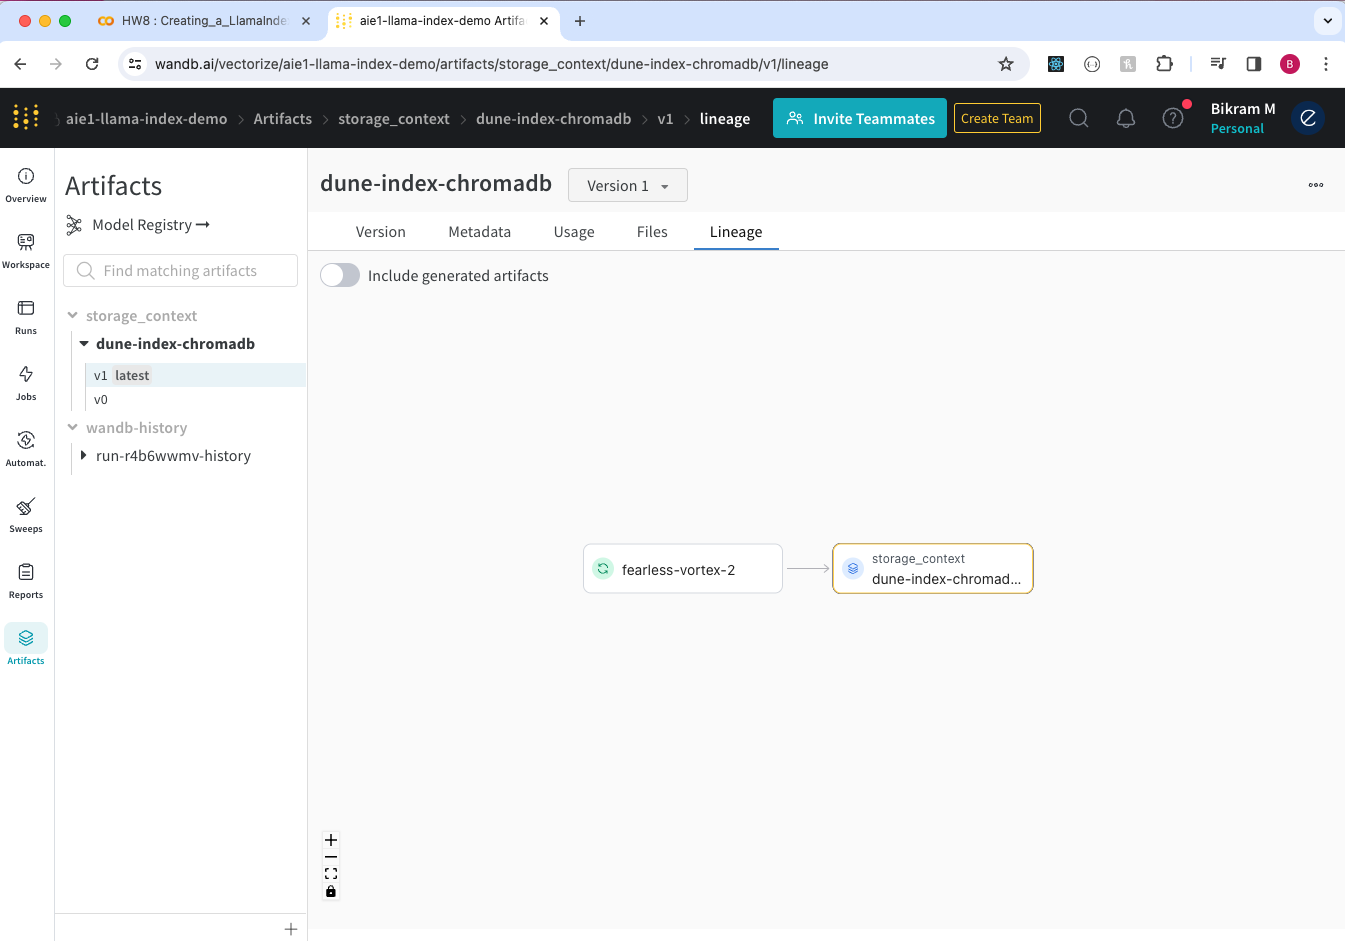

### Auto Retriever Functional Tool

This tool will leverage OpenAI's functional endpoint to select the correct metadata filter and query the filtered index - only looking at nodes with the desired metadata.

A simplified diagram: ![image](https://i.imgur.com/AICDPav.png)

First, we need to create our `VectoreStoreInfo` object which will hold all the relevant metadata we need for each component (in this case title metadata).

Notice that you need to include it in a text list.

In [38]:
from llama_index.core.tools import FunctionTool
from llama_index.core.vector_stores.types import (
    VectorStoreInfo,
    MetadataInfo,
    ExactMatchFilter,
    MetadataFilters,
)
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

from typing import List, Tuple, Any
from pydantic import BaseModel, Field

top_k = 3

vector_store_info = VectorStoreInfo(
    content_info="semantic information about movies",
    metadata_info=[MetadataInfo(
        name="title",
        type="str",
        description="title of the movie, one of ['Dune (2021 film)', 'Dune: Part 2']",
    )]
)

Now we'll create our base PyDantic object that we can use to ensure compatability with our application layer. This verifies that the response from the OpenAI endpoint conforms to this schema.

In [39]:
class AutoRetrieveModel(BaseModel):
    query: str = Field(..., description="natural language query string")
    filter_key_list: List[str] = Field(
        ..., description="List of metadata filter field names"
    )
    filter_value_list: List[str] = Field(
        ...,
        description=(
            "List of metadata filter field values (corresponding to names specified in filter_key_list)"
        )
    )

Now we can build our function that we will use to query the functional endpoint.

In [40]:
def auto_retrieve_fn(
    query: str, filter_key_list: List[str], filter_value_list: List[str]
):
    """Auto retrieval function.

    Performs auto-retrieval from a vector database, and then applies a set of filters.

    """
    query = query or "Query"

    exact_match_filters = [
        ExactMatchFilter(key=k, value=v)
        for k, v in zip(filter_key_list, filter_value_list)
    ]
    retriever = VectorIndexRetriever(
        index, filters=MetadataFilters(filters=exact_match_filters), top_k=top_k
    )
    query_engine = RetrieverQueryEngine.from_args(retriever)

    response = query_engine.query(query)
    return str(response)

Now we need to wrap our system in a tool in order to integrate it into the larger application.

Source Code Here:
- [`FunctionTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/function_tool.py#L21)

In [41]:
description = f"""\
Use this tool to look up semantic information about films.
The vector database schema is given below:
{vector_store_info.json()}
"""

auto_retrieve_tool = FunctionTool.from_defaults(
    fn=auto_retrieve_fn,
    name="semantic-film-info",
    description=description,
    fn_schema=AutoRetrieveModel
)

####❓ Question #3:

Is the text in the description of our `FunctionTool` important or not? Please explain your answer.


### **ANSWER:
Yes, the description tool is important. It helps with natural language descrption, helps the agent to decide what tool to use, provide references to the vector db schema and similar context.

All that's left to do is attach the tool to an OpenAIAgent and let it rip!

Source Code Here:
- [`OpenAIAgent`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/agent/openai_agent.py#L361)

In [42]:
from llama_index.agent.openai import OpenAIAgent

agent = OpenAIAgent.from_tools(
    tools=[auto_retrieve_tool],
    verbose=True,
)

In [43]:
response = agent.chat("Who starred in the 2021 film?")
print(str(response))

Added user message to memory: Who starred in the 2021 film?
=== Calling Function ===
Calling function: semantic-film-info with args: {"query":"cast of the 2021 film","filter_key_list":["title"],"filter_value_list":["Dune (2021 film)"]}
Got output: The cast of the 2021 film "Dune" includes Timothée Chalamet, Rebecca Ferguson, Dave Bautista, Stellan Skarsgård, Charlotte Rampling, Oscar Isaac, Zendaya, Javier Bardem, Josh Brolin, Jason Momoa, David Dastmalchian, Stephen McKinley Henderson, Chang Chen, Benjamin Clementine, and Sharon Duncan-Brewster.



wandb: Logged trace tree to W&B.


The cast of the 2021 film "Dune" includes Timothée Chalamet, Rebecca Ferguson, Dave Bautista, Stellan Skarsgård, Charlotte Rampling, Oscar Isaac, Zendaya, Javier Bardem, Josh Brolin, Jason Momoa, David Dastmalchian, Stephen McKinley Henderson, Chang Chen, Benjamin Clementine, and Sharon Duncan-Brewster.


# 🤝 Breakout Room #2

## Task 1: Quantitative RAG Pipeline with NL2SQL Tooling

We'll walk through the steps of creating a natural language to SQL system in the following section.

> NOTICE: This does not have parsing on the inputs or intermediary calls to ensure that users are using safe SQL queries. Use this with caution in a production environment without adding specific guardrails from either side of the application.

The next few steps should be largely straightforward, we'll want to:

1. Read in our `.csv` files into `pd.DataFrame` objects
2. Create an in-memory `sqlite` powered `sqlalchemy` engine
3. Cast our `pd.DataFrame` objects to the SQL engine
4. Create an `SQLDatabase` object through LlamaIndex
5. Use that to create a `QueryEngineTool` that we can interact with through the `NLSQLTableQueryEngine`!

If you get stuck, please consult the documentation.

In [44]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv

--2024-03-12 19:30:17--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133391 (130K) [text/plain]
Saving to: ‘dune1.csv’

dune1.csv           100%[===================>] 130.26K  --.-KB/s    in 0.02s   

2024-03-12 19:30:18 (8.34 MB/s) - ‘dune1.csv’ saved [133391/133391]



In [45]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv

--2024-03-12 19:30:19--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111843 (109K) [text/plain]
Saving to: ‘dune2.csv’

dune2.csv           100%[===================>] 109.22K  --.-KB/s    in 0.01s   

2024-03-12 19:30:19 (7.20 MB/s) - ‘dune2.csv’ saved [111843/111843]



#### Read `.csv` Into Pandas

In [46]:
import pandas as pd

dune1_df = pd.read_csv("./dune1.csv")
dune2_df = pd.read_csv("./dune2.csv")

#### Create SQLAlchemy engine with SQLite

In [47]:
from sqlalchemy import create_engine

engine = create_engine("sqlite+pysqlite:///:memory:")

#### Convert `pd.DataFrame` to SQL tables

In [48]:
dune1_df.to_sql(
    "Dune (2021 film)",
    engine
)

274

In [49]:
dune2_df.to_sql(
    "Dune: Part 2",
    engine
)

175

#### Construct a `SQLDatabase` index

Source Code Here:
- [`SQLDatabase`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/langchain_helpers/sql_wrapper.py#L9)

In [50]:
from llama_index.core import SQLDatabase

sql_database = SQLDatabase(
    engine=engine,
    include_tables=["Dune (2021 film)", "Dune: Part 2"]
)

#### Create the NLSQLTableQueryEngine interface for all added SQL tables

Source Code Here:
- [`NLSQLTableQueryEngine`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/indices/struct_store/sql_query.py#L75C1-L75C1)

In [51]:
from llama_index.core.indices.struct_store.sql_query import NLSQLTableQueryEngine

sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["Dune (2021 film)", "Dune: Part 2"],
)

#### Wrap It All Up in a `QueryEngineTool`

You'll want to ensure you have a descriptive...description.

An example is provided here:

```
Useful for translating a natural language query into a SQL query over a table containing:
John Wick 1, containing information related to reviews of the first John Wick movie, called John Wick
John Wick 2, containing information related to reviews of the second John Wick movie, called John Wick: Chapter 2
John Wick 3, containing information related to reviews of the third John Wick movie, called John Wick: Chatper 3 - Parabellum
John Wick 4, containing information related to reviews of the fourth John Wick movie, called John Wick: Chatper 4
```

Sorce Code Here:

- [`QueryEngineTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/query_engine.py#L13)

####🏗️ Activity #1:

Please write a Natural Language Description for the tables that we are using today.

In [52]:
DESCRIPTION = """\

You function as a translator, converting natural language requests into SQL queries for tables that hold information on:

Reviews of the initial Dune movie, titled "Dune (2021 film)"
Reviews of the sequel, referred to as "Dune: Part 2"

It is also referenced in the following way:
1. Dune (2021 film)
2. Dune: Part 2

"""

In [53]:
from llama_index.core.tools.query_engine import QueryEngineTool

sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    name="sql-query",
    description=DESCRIPTION,
)

In [54]:
agent = OpenAIAgent.from_tools(
    tools=[sql_tool],
    verbose=True
)

In [55]:
response = agent.chat("What is the average rating of the 2nd Dune movie?")

Added user message to memory: What is the average rating of the 2nd Dune movie?
=== Calling Function ===
Calling function: sql-query with args: {"input":"SELECT AVG(rating) AS average_rating FROM reviews WHERE movie_title = 'Dune: Part 2'"}
Got output: The average rating for "Dune: Part 2" is 8.71.



wandb: Logged trace tree to W&B.


In [56]:
print(str(response))

The average rating for the 2nd Dune movie, "Dune: Part 2," is 8.71.


### Task 2: Combined RAG Pipeline

Now, we can simply add our tools into the `OpenAIAgent`, and off we go!

In [57]:
dune_agent = OpenAIAgent.from_tools(
    tools=[auto_retrieve_tool, sql_tool],
    verbose=True
)

In [58]:
response = dune_agent.chat("What is the lowest rating of the 1st film?")

Added user message to memory: What is the lowest rating of the 1st film?
=== Calling Function ===
Calling function: sql-query with args: {"input":"lowest rating of the 1st film"}
Got output: The lowest rating of the first film "Dune (2021)" is 1.0.



wandb: Logged trace tree to W&B.


In [59]:
print(str(response))

The lowest rating of the first film "Dune (2021)" is 1.0.


In [60]:
response = dune_agent.chat("What planet does the 1st Dune movie take place on?")

Added user message to memory: What planet does the 1st Dune movie take place on?
=== Calling Function ===
Calling function: semantic-film-info with args: {"query":"planet where the 1st Dune movie takes place","filter_key_list":["title"],"filter_value_list":["Dune (2021 film)"]}
Got output: Arrakis



wandb: Logged trace tree to W&B.


In [61]:
print(str(response))

The first Dune movie takes place on the planet Arrakis.


In [62]:
response = dune_agent.chat("Calculate the average review of each movie - and then discuss how the average review changed over time.")

Added user message to memory: Calculate the average review of each movie - and then discuss how the average review changed over time.
=== Calling Function ===
Calling function: sql-query with args: {"input": "average review of Dune (2021 film)"}
Got output: The average review rating for the film "Dune" (2021) is approximately 8.34 out of 10.

=== Calling Function ===
Calling function: sql-query with args: {"input": "average review of Dune: Part 2"}
Got output: The average review for Dune: Part 2 is 8.71 out of 10.



wandb: Logged trace tree to W&B.


In [63]:
print(str(response))

The average review rating for the film "Dune (2021)" is approximately 8.34 out of 10, and for "Dune: Part 2" is 8.71 out of 10.

Discussing how the average review changed over time:
- The average review for "Dune (2021)" is slightly lower at 8.34 compared to "Dune: Part 2" at 8.71.
- The increase in the average review score from the first film to the sequel indicates a positive reception and potentially an improvement in the sequel's storytelling, performances, or overall impact on the audience.
- The increase in the average review score suggests that "Dune: Part 2" was well-received by viewers, possibly building on the success and quality of the first film.


In [64]:

# Try out examples
response = dune_agent.chat("Based on the Dune part 1 and Dune part 2, what is the movie Dune 3 going to be about? You can give your best guess")
print(str(response))

Added user message to memory: Based on the Dune part 1 and Dune part 2, what is the movie Dune 3 going to be about? You can give your best guess


wandb: Logged trace tree to W&B.


To provide a speculative answer on what the movie "Dune 3" might be about based on "Dune Part 1" and "Dune Part 2," we can consider the continuation of the storyline from the original Dune series by Frank Herbert. 

Given the complex and rich universe of Dune, "Dune 3" could potentially explore the following themes or storylines:
1. **Further Exploration of Arrakis**: The planet Arrakis, with its valuable spice melange and intricate political dynamics, could continue to be a central focus in "Dune 3."
2. **Rise of New Characters**: Introducing new characters or further developing existing ones to navigate the power struggles, alliances, and conflicts within the Dune universe.
3. **Continuation of the Atreides Saga**: Following the journey of House Atreides and its members, including Paul Atreides, as they face new challenges and revelations.
4. **Political Intrigues and Betrayals**: Delving deeper into the political landscape of the Imperium, the Bene Gesserit, the Spacing Guild, and o

In [65]:
response = dune_agent.chat("How did Paul Altrides character evolve from Dune 1 to Dune 2? respond in a list")
print(str(response))

Added user message to memory: How did Paul Altrides character evolve from Dune 1 to Dune 2? respond in a list
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "evolution of Paul Atreides character in Dune (2021 film)", "filter_key_list": ["title"], "filter_value_list": ["Dune (2021 film)"]}
Got output: The evolution of Paul Atreides' character in the Dune (2021) film showcases his journey from a ducal heir of House Atreides to a young man who undergoes intense premonitions triggered by his exposure to spice. As the story progresses, Paul faces assassination attempts, betrayal, and the invasion of Arrakis, leading to pivotal moments where he displays courage, strategic thinking, and a growing sense of responsibility. His encounters with different characters, such as Duncan, Kynes, and Stilgar, shape his understanding of the world around him and his role in the unfolding events. Ultimately, Paul's decision to join the Fremen tribe reflects his determinat

wandb: Logged trace tree to W&B.


The evolution of Paul Atreides' character from "Dune (2021)" to "Dune: Part 2" can be summarized as follows:

**Dune (2021 film):**
1. Paul Atreides starts as a ducal heir of House Atreides.
2. He experiences intense premonitions triggered by his exposure to spice.
3. Faces assassination attempts, betrayal, and the invasion of Arrakis.
4. Displays courage, strategic thinking, and a growing sense of responsibility.
5. Interacts with characters like Duncan, Kynes, and Stilgar, shaping his understanding of the world.
6. Joins the Fremen tribe, showing determination to fulfill his father's goals and bring peace to Arrakis.

**Dune: Part 2:**
1. (No specific information provided in the response)

The evolution of Paul Atreides' character in "Dune (2021)" showcases his growth from a young heir facing challenges to a determined leader embracing his destiny and responsibilities.


####❓ Question #4:

How can you verify which tool was used for which query?

### **ANSWER:
We can use a method `response.sources`. Answer for this context is `['semantic-film-info', 'semantic-film-info']`

In [66]:

response.sources


[ToolOutput(content="The evolution of Paul Atreides' character in the Dune (2021) film showcases his journey from a ducal heir of House Atreides to a young man who undergoes intense premonitions triggered by his exposure to spice. As the story progresses, Paul faces assassination attempts, betrayal, and the invasion of Arrakis, leading to pivotal moments where he displays courage, strategic thinking, and a growing sense of responsibility. His encounters with different characters, such as Duncan, Kynes, and Stilgar, shape his understanding of the world around him and his role in the unfolding events. Ultimately, Paul's decision to join the Fremen tribe reflects his determination to fulfill his father's goals and bring peace to Arrakis, marking a significant transformation in his character throughout the film.", tool_name='semantic-film-info', raw_input={'args': (), 'kwargs': {'query': 'evolution of Paul Atreides character in Dune (2021 film)', 'filter_key_list': ['title'], 'filter_value

In [68]:
tool_names = [source.tool_name for source in response.sources]
tool_names

['semantic-film-info', 'semantic-film-info']

In [69]:
wandb_callback.finish()